## Overview 
I now have ample high quality masks for tdTom across multiple similar but distinct imaging conditions. The idea is to use these to train a generalist CellPose classifier that I can hopefully use without adjustment for all new tdTom experiments on the YX1

In [1]:
import os
import numpy as np
import skimage.io as io

In [2]:
# get paths to old  data files
experiment_date_vec = ["20240223", "20240424", "20240425"]
mask_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/built_data/stitched_labels_archive/"
zarr_root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/built_data/zarr_image_files/"
# zarr_root = "/media/nick/hdd01/old_pecfin_data/built_data/"
model_name_vec = ["log-v5", "log-v3", "log-v3"]
nuclear_channel_vec = [0, 1, 1]
channel_names_vec = [["H2B-tdTom"], ["tbx5a-StayGold", "H2B-tdTom"], ["tbx5a-StayGold", "H2B-tdTom"]]

In [3]:
# set output directory
out_dir = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/built_data/cellpose_training/tdTom_log/"

# set export parameters
n_points_per_well = 3

In [17]:
import glob2 as glob 
import zarr 
from src.utilities.functions import path_leaf
from scipy.ndimage import zoom
from src.utilities.image_utils import calculate_LoG
from tqdm import tqdm

mask_keys = ['outlines', 'colors', 'masks', 'chan_choose', 'filename', 'flows', \
             'ismanual', 'manual_changes', 'model_path', 'flow_threshold', 'cellprob_threshold']

# iterate through project folders and pull 2D sample slices for training
for p in tqdm(range(len(experiment_date_vec)), "Looping through experiments..."):
    experiment_date = experiment_date_vec[p]
    model_name = model_name_vec[p]
    nuclear_channel = nuclear_channel_vec[p]
    
    image_folder = os.path.join(zarr_root, experiment_date, "")
    mask_folder = os.path.join(mask_root, model_name, experiment_date, "")
    mask_list = sorted(glob.glob(mask_folder + "*_stitched.zarr"))
    
    for z, mask_file in enumerate(tqdm(mask_list, "Looping through wells...")):
        # load
        mask = zarr.open(mask_file, mode="r")
        im_name = path_leaf(mask_file).replace("_labels_stitched", "")
        image = zarr.open(os.path.join(image_folder, im_name), mode="r")
    
        # get metadata
        voxel_size_um = image.attrs["voxel_size_um"]
        dims = image.attrs["zyx_shape"]
        n_time_points = image.shape[0]

        multichannel_flag = len(image.shape) >= 5
        time_points = np.random.choice(range(n_time_points), n_points_per_well, replace=True)
    
        for t in tqdm(time_points, "Looping through time points..."):

            if not multichannel_flag:
                zyx_raw = image[t]
                zyx_mask = mask[t]
            else:
                zyx_raw = image[nuclear_channel, t]
                zyx_mask = mask[t]


            if len(np.unique(zyx_mask)) > 100:
    
                zyx_image, _ = calculate_LoG(data_zyx=zyx_raw, scale_vec=voxel_size_um)
                
                # select slices to sample
                zi = np.random.choice(range(dims[0]), 1)[0]
                yi = np.random.choice(range(dims[1]), 1)[0]
                xi = np.random.choice(range(dims[2]), 1)[0]
        
                # extract
                im_xy = np.squeeze(zyx_image[zi])
                ma_xy = np.squeeze(zyx_mask[zi])
                im_xz = np.squeeze(zyx_image[:, yi, :])
                ma_xz = np.squeeze(zyx_mask[:, yi, :])
                im_yz = np.squeeze(zyx_image[: ,:, xi])
                ma_yz = np.squeeze(zyx_mask[:, :, xi])
        
                # resample along z
                as_factor = voxel_size_um[0] / voxel_size_um[1]
        
                im_xz = zoom(im_xz, tuple([as_factor, 1]), order=1) 
                ma_xz = zoom(ma_xz, tuple([as_factor, 1]), order=0) 
        
                im_yz = zoom(im_yz, tuple([as_factor, 1]), order=1) 
                ma_yz = zoom(ma_yz, tuple([as_factor, 1]), order=0) 
        
                # save
                out_name = im_name.replace(".zarr", "") + f"_t{t:04}"
        
                io.imsave(os.path.join(out_dir, "xy_" + out_name + ".tif"), im_xy, check_contrast=False)
                # io.imsave(os.path.join(out_dir, "xy_" + out_name + "_masks.tif"), ma_xy, check_contrast=False)
                lb_xy_out = os.path.join(out_dir, "xy_" + out_name + "_seg.npy")
                xy_mask_dict = dict({})#.fromkeys(mask_keys)
                xy_mask_dict["masks"] = ma_xy
                xy_mask_dict["outlines"] = []
                xy_mask_dict["flows"] = [[], [], [], [], [[]]]
                xy_mask_dict["filename"] = os.path.join(out_dir, "xy_" + out_name + ".tif")
                xy_mask_dict["chan_choose"] = [0, 0]
                np.save(lb_xy_out, np.asarray(xy_mask_dict))
        
                io.imsave(os.path.join(out_dir, "xz_" + out_name + ".tif"), im_xz, check_contrast=False)
                # io.imsave(os.path.join(out_dir, "xz_" + out_name + "_masks.tif"), ma_xz, check_contrast=False)
                lb_xz_out = os.path.join(out_dir, "xz_" + out_name + "_seg.npy")
                xz_mask_dict = dict({})
                xz_mask_dict["masks"] = ma_xz
                xz_mask_dict["outlines"] = []
                xz_mask_dict["flows"] = [[], [], [], [], [[]]]
                xz_mask_dict["filename"] = os.path.join(out_dir, "xz_" + out_name + ".tif")
                xz_mask_dict["chan_choose"] = [0, 0]
                np.save(lb_xz_out, np.asarray(xz_mask_dict))
        
                io.imsave(os.path.join(out_dir, "yz_" + out_name + ".tif"), im_yz, check_contrast=False)
                # io.imsave(os.path.join(out_dir, "yz_" + out_name + "_masks.tif"), ma_yz, check_contrast=False)
                lb_yz_out = os.path.join(out_dir, "yz_" + out_name + "_seg.npy")
                yz_mask_dict = dict({})
                yz_mask_dict["masks"] = ma_yz
                yz_mask_dict["outlines"] = []
                yz_mask_dict["flows"] = [[], [], [], [], [[]]]
                yz_mask_dict["filename"] = os.path.join(out_dir, "yz_" + out_name + ".tif")
                yz_mask_dict["chan_choose"] = [0, 0]
                np.save(lb_yz_out, np.asarray(yz_mask_dict))


Looping through wells...:   0%|          | 0/4 [00:00<?, ?it/s]

Looping through time points...:   0%|          | 0/3 [00:00<?, ?it/s]

Looping through time points...:  33%|███▎      | 1/3 [00:00<00:00,  2.11it/s]

Looping through time points...:  67%|██████▋   | 2/3 [00:15<00:08,  8.83s/it]

Looping through time points...: 100%|██████████| 3/3 [00:29<00:00,  9.85s/it]

Looping through wells...:  25%|██▌       | 1/4 [00:29<01:28, 29.61s/it]

Looping through time points...:   0%|          | 0/3 [00:00<?, ?it/s]

Looping through time points...:  33%|███▎      | 1/3 [00:14<00:28, 14.21s/it]

Looping through time points...:  67%|██████▋   | 2/3 [00:28<00:14, 14.20s/it]

Looping through time points...: 100%|██████████| 3/3 [00:42<00:00, 14.20s/it]

Looping through wells...:  50%|█████     | 2/4 [01:12<01:14, 37.25s/it]

Looping through time points...:   0%|          | 0/3 [00:00<?, ?it/s]

Looping through time points...:  33%|███▎      | 1/3 [00:00<00:00,  3.42it/s]

Looping through time po

In [11]:
zyx_image.shape

(51, 958, 652)

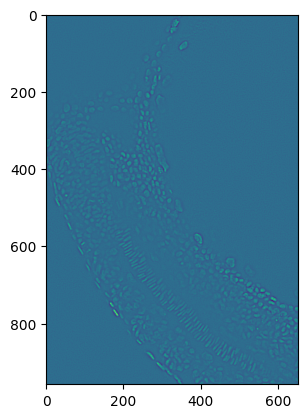

In [13]:
from matplotlib import pyplot as plt
plt.imshow(im_xy)
plt.show()

In [16]:
np.unique(zyx_mask)

array([0], dtype=uint16)

In [96]:
test_path = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/built_data/cellpose_training/tdTom_log/yz_20240223_well0002_t0000_seg.npy"

test_labels = np.load(test_path, allow_pickle=True)

In [97]:
test = test_labels.tolist()
test.keys()

dict_keys(['outlines', 'colors', 'masks', 'chan_choose', 'filename', 'flows', 'ismanual', 'manual_changes', 'model_path', 'flow_threshold', 'cellprob_threshold', 'normalize_params', 'restore', 'ratio', 'diameter'])

In [98]:
test["filename"]

"/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/built_data/cellpose_training/tdTom_log/yz_20240223_well0002_t0000.tif"